# WhatsApp Chat Analysis

## 1. Import Packages & Define Functions

File to be used: '../Data/clean_whatsapp.csv'

In [149]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import re
import emoji
import matplotlib.pyplot as plt

In [80]:
df = pd.read_csv('../Data/clean_whatsapp.csv', index_col = 0)
df.head()

,datetime,name,message
0,"29/08/2018, 16:57",David,ahhhh
1,"29/08/2018, 16:57",David,and any tomato?
2,"29/08/2018, 16:58",Iubire,yep
3,"29/08/2018, 16:59",David,nice
4,"29/08/2018, 16:59",David,omw


## 2. Counts

### 2.1. Total message count

In [81]:
msg_counts = df.groupby('name').size().reset_index(name = 'msg_count')
msg_counts

,name,msg_count
0,David,18687
1,Iubire,21312


### 2.2. Word count

In [82]:
def word_count(line):
    
    count = len(re.findall(r'\w+', line))
    
    return count

In [83]:
df['num_words'] = df['message'].apply(word_count)
df.head()

,datetime,name,message,num_words
0,"29/08/2018, 16:57",David,ahhhh,1
1,"29/08/2018, 16:57",David,and any tomato?,3
2,"29/08/2018, 16:58",Iubire,yep,1
3,"29/08/2018, 16:59",David,nice,1
4,"29/08/2018, 16:59",David,omw,1


In [84]:
word_counts = df.groupby('name')['num_words'].agg('sum').reset_index(name = 'word_count')
word_counts

,name,word_count
0,David,129384
1,Iubire,103891


### 2.3. Words per Message

In [85]:
df_counts = msg_counts.merge(word_counts, on = 'name')
df_counts['words_per_message'] = df_counts['word_count']/df_counts['msg_count']
df_counts

,name,msg_count,word_count,words_per_message
0,David,18687,129384,6.923744
1,Iubire,21312,103891,4.874765


### 2.4. Media Count

In [86]:
df_media = df.loc[df['message'] == '<media omitted>']
df_media = df_media.groupby('name')['message'].agg('count').reset_index(name = 'num_media')
df_media

,name,num_media
0,David,856
1,Iubire,924


In [87]:
df_counts = df_counts.merge(df_media, on = 'name')
df_counts

,name,msg_count,word_count,words_per_message,num_media
0,David,18687,129384,6.923744,856
1,Iubire,21312,103891,4.874765,924


### 2.5. Emoji Count

In [88]:
def emoji_count(text):
    
    emoji_counter = 0
    for word in text:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_counter += 1

    return emoji_counter

In [89]:
df['num_emojis'] = df['message'].apply(emoji_count)
df.head()

,datetime,name,message,num_words,num_emojis
0,"29/08/2018, 16:57",David,ahhhh,1,0
1,"29/08/2018, 16:57",David,and any tomato?,3,0
2,"29/08/2018, 16:58",Iubire,yep,1,0
3,"29/08/2018, 16:59",David,nice,1,0
4,"29/08/2018, 16:59",David,omw,1,0


In [90]:
df_emoji = df.groupby('name')['num_emojis'].agg('sum').reset_index(name = 'num_emojis')
df_emoji

,name,num_emojis
0,David,17140
1,Iubire,10998


In [91]:
df_counts = df_counts.merge(df_emoji, on = 'name')
df_counts

,name,msg_count,word_count,words_per_message,num_media,num_emojis
0,David,18687,129384,6.923744,856,17140
1,Iubire,21312,103891,4.874765,924,10998


## 3. Activity Heatmap

In [93]:
df.head()

,datetime,name,message,num_words,num_emojis
0,"29/08/2018, 16:57",David,ahhhh,1,0
1,"29/08/2018, 16:57",David,and any tomato?,3,0
2,"29/08/2018, 16:58",Iubire,yep,1,0
3,"29/08/2018, 16:59",David,nice,1,0
4,"29/08/2018, 16:59",David,omw,1,0


In [98]:
df['datetime'] = pd.to_datetime(df['datetime'], format = '%d/%m/%Y, %H:%S')

In [108]:
df['week_day'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour
df.head()

,index,datetime,name,message,num_words,num_emojis,week_day,hour
0,0,2018-08-29 16:00:57,David,ahhhh,1,0,2,16
1,1,2018-08-29 16:00:57,David,and any tomato?,3,0,2,16
2,2,2018-08-29 16:00:58,Iubire,yep,1,0,2,16
3,3,2018-08-29 16:00:59,David,nice,1,0,2,16
4,4,2018-08-29 16:00:59,David,omw,1,0,2,16


In [127]:
df_weekhour = df.groupby(['week_day', 'hour'])['num_words'].agg(['count','sum']).reset_index()
df_weekhour = df_weekhour.rename(columns = {'count':'num_msgs','sum':'num_words'})
df_weekhour['week_day'] = df_weekhour['week_day'].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
df_weekhour.head()

,week_day,hour,num_msgs,num_words
0,Monday,0,53,312
1,Monday,1,49,183
2,Monday,2,21,102
3,Monday,3,7,30
4,Monday,4,3,7


In [128]:
df_weekday = df_weekhour.groupby('week_day')['num_msgs'].agg('sum').reset_index()
df_weekday

,week_day,num_msgs
0,Friday,7604
1,Monday,6925
2,Saturday,2699
3,Sunday,2504
4,Thursday,6678
5,Tuesday,7050
6,Wednesday,6539


In [164]:
pivot = df_weekhour.pivot(index = 'week_day', columns = 'hour', values = 'num_msgs')
pivot = pivot.fillna(0)
pivot = pivot.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
pivot

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
week_day,,,,,,,,,,,,,,,,,,,,,
Monday,53.0,49.0,21.0,7.0,3.0,7.0,130.0,144.0,490.0,419.0,...,320.0,268.0,315.0,318.0,522.0,533.0,699.0,729.0,510.0,175.0
Tuesday,139.0,78.0,32.0,10.0,0.0,0.0,4.0,82.0,284.0,486.0,...,275.0,341.0,320.0,315.0,560.0,721.0,608.0,513.0,389.0,312.0
Wednesday,104.0,58.0,14.0,6.0,23.0,5.0,0.0,54.0,303.0,424.0,...,448.0,375.0,455.0,365.0,373.0,555.0,454.0,287.0,311.0,266.0
Thursday,111.0,8.0,25.0,7.0,7.0,2.0,2.0,68.0,413.0,350.0,...,318.0,403.0,403.0,592.0,470.0,597.0,317.0,336.0,331.0,229.0
Friday,89.0,51.0,3.0,4.0,8.0,4.0,7.0,133.0,276.0,422.0,...,456.0,528.0,497.0,495.0,416.0,520.0,481.0,443.0,407.0,474.0
Saturday,238.0,192.0,16.0,49.0,2.0,2.0,2.0,43.0,370.0,424.0,...,50.0,63.0,110.0,95.0,27.0,74.0,174.0,124.0,69.0,63.0
Sunday,52.0,32.0,12.0,0.0,20.0,0.0,2.0,1.0,42.0,53.0,...,170.0,121.0,162.0,118.0,199.0,207.0,145.0,298.0,357.0,133.0


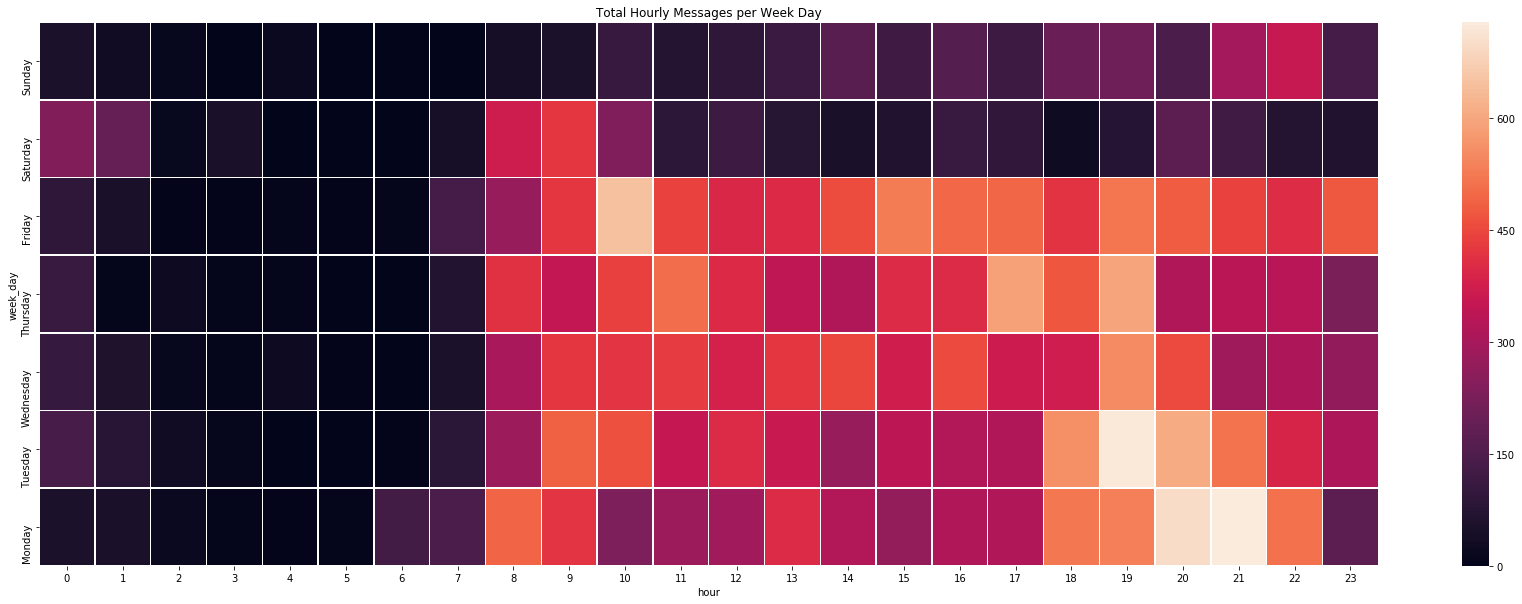

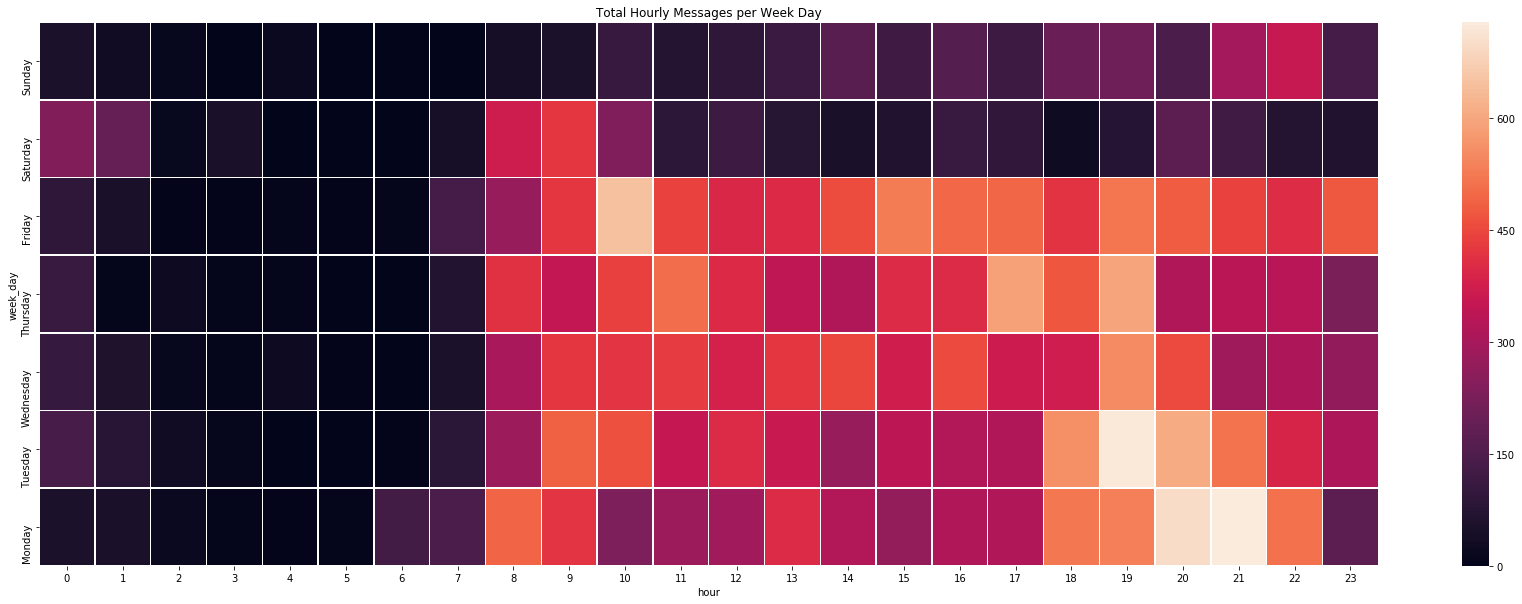

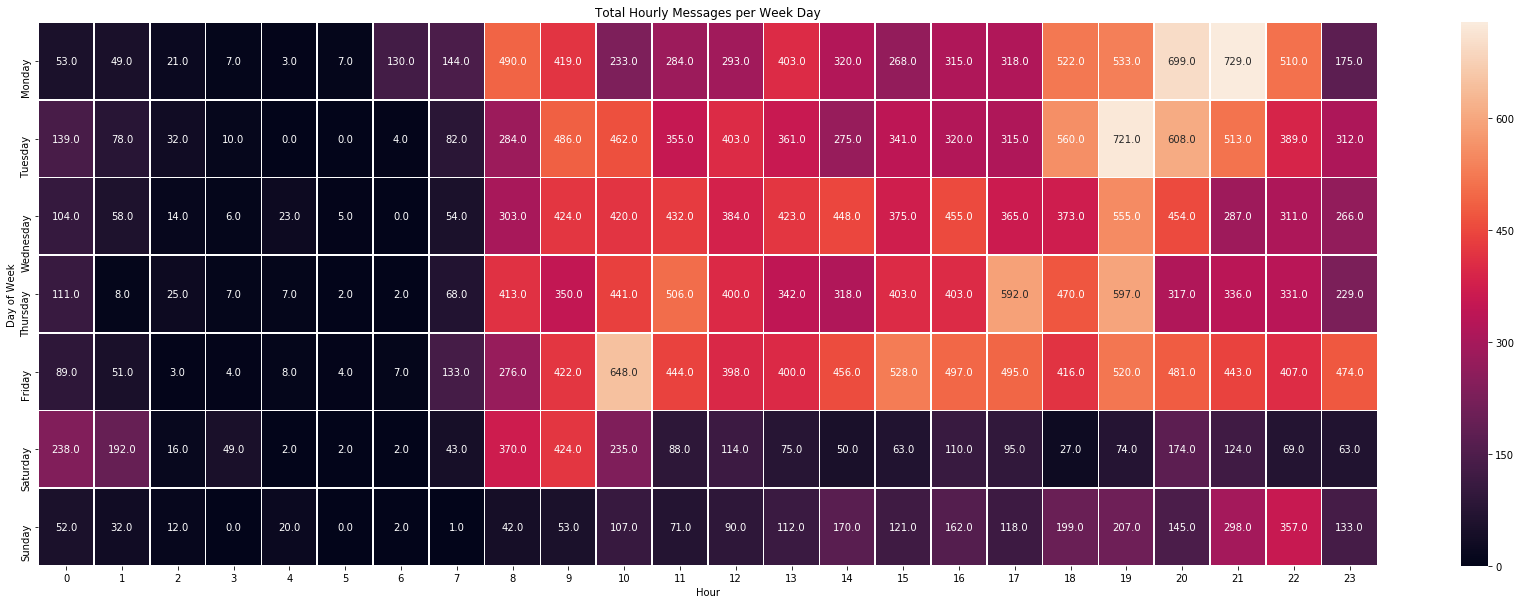

In [180]:
#pivot = df_weekhour.pivot(index = 'hour', columns = 'week_day', values = 'num_msgs')
plt.subplots(figsize=(30,10))
plt.title('Total Hourly Messages per Week Day')

ax = sns.heatmap(pivot, linewidths = .5, annot = True, fmt=".1f")

plt.xlabel('Hour')
plt.ylabel('Day of Week')
plt.show()

References:

https://regexr.com/ 
